In [1]:
%%capture
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab Notebooks/WhenPigsFlyContext/baselines/IVSN

! pip install ml-collections

In [2]:
import sys
import cv2
import time
from matplotlib import pyplot as plt
from tqdm import tqdm, trange
import numpy as np
import pandas as pd
import pickle
import random
import copy

import os
import shutil
from PIL import Image, ImageDraw

import torch
from torch.utils.data import Dataset
from torchvision.transforms.functional import to_tensor, normalize
from torchvision import transforms

from utils import *
from naturaldesign.naturaldesign import NaturalDesign
sys.path.append("..")

In [3]:
test_imagedir = "../../naturaldesign/"
context_size, target_size = (512, 512), (32, 32)
dataset = NaturalDesign(test_imagedir, context_size, target_size)

In [4]:
# define IVSN model
class IVSN_sti(nn.Module):
  def __init__(self, model):
      super(IVSN_sti, self).__init__()
      self.features = nn.Sequential(*list(model.children())[0][:30])
      for param in self.features.parameters():
        param.requires_grad_ = False

  def forward(self, x):
      x = self.features(x)
      return x

class IVSN_tg(nn.Module):
  def __init__(self, model):
      super(IVSN_tg, self).__init__()
      self.features = nn.Sequential(*list(model.children())[0][:30])
    #   self.pool_layer = nn.AdaptiveMaxPool2d((1, 1))
      for param in self.features.parameters():
        param.requires_grad_ = False

  def forward(self, x):
      x = self.features(x)
    #   x = self.pool_layer(x)
      return x

from torch.nn.modules.conv import Conv2d
ConvSize, NumTemplates, Mylayer = 1, 512, 31
MMconv = Conv2d(NumTemplates, 1, kernel_size = (ConvSize, ConvSize), stride = (1, 1), padding = (1, 1))

In [5]:
model_vgg = models.vgg16(pretrained=True)
model_ivsn_sti = IVSN_sti(model_vgg)
model_ivsn_tg = IVSN_tg(model_vgg)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [6]:
num_pics, size, image_size = len(dataset), 200, (1024, 1280)
IVSN_res = list()
IVSN_attention_map, scanpath = {}, {}

model_ivsn_sti.eval()
model_ivsn_tg.eval()
with torch.no_grad():
    for id in trange(1, num_pics+1):
        context_images, target_images, bbox = dataset[id]

        # get attention map from IVSN model
        # context_images = transforms.Resize(image_size)(context_images)
        context_ivsn = context_images.unsqueeze(0)
        target_ivsn = target_images.unsqueeze(0)
        cont_output_ivsn = model_ivsn_sti(context_ivsn)
        tg_output_ivsn = model_ivsn_tg(target_ivsn)
        MMconv.weight = torch.nn.Parameter(tg_output_ivsn)
        attention_IVSN = MMconv.forward(cont_output_ivsn)
        attention_IVSN = attention_IVSN.detach().squeeze(0)

        tg_loc = bbox_cordinates(bbox, image_size[1], image_size[0])

        # process IVSN attention map
        mask_IVSN = transforms.Resize(image_size)(attention_IVSN)
        mask_IVSN = torch.divide(mask_IVSN, mask_IVSN.max())

        IVSN_attention_map[id] = copy.deepcopy(mask_IVSN)

        IVSN_num, path = searchProcesswithPath(tg_loc, mask_IVSN, image_size, size)
        scanpath[id] = path
        IVSN_res.append(IVSN_num)
        print('IVSN_' + str(id) + ': ' + str(IVSN_num), end = '\t')

  0%|          | 1/240 [00:06<26:53,  6.75s/it]

IVSN_1: 3	

  1%|          | 2/240 [00:11<20:59,  5.29s/it]

IVSN_2: 6	

  1%|▏         | 3/240 [00:16<20:26,  5.17s/it]

IVSN_3: 9	

  2%|▏         | 4/240 [00:19<17:42,  4.50s/it]

IVSN_4: 12	

  2%|▏         | 5/240 [00:23<16:21,  4.17s/it]

IVSN_5: 7	

  2%|▎         | 6/240 [00:26<15:41,  4.02s/it]

IVSN_6: 1	

  3%|▎         | 7/240 [00:30<15:06,  3.89s/it]

IVSN_7: 7	

  3%|▎         | 8/240 [00:34<14:50,  3.84s/it]

IVSN_8: 6	

  4%|▍         | 9/240 [00:37<14:39,  3.81s/it]

IVSN_9: 36	

  4%|▍         | 10/240 [00:41<14:09,  3.70s/it]

IVSN_10: 16	

  5%|▍         | 11/240 [00:45<14:12,  3.72s/it]

IVSN_11: 4	

  5%|▌         | 12/240 [00:48<13:59,  3.68s/it]

IVSN_12: 6	

  5%|▌         | 13/240 [00:52<13:50,  3.66s/it]

IVSN_13: 12	

  6%|▌         | 14/240 [00:55<13:44,  3.65s/it]

IVSN_14: 4	

  6%|▋         | 15/240 [00:59<13:33,  3.61s/it]

IVSN_15: 6	

  7%|▋         | 16/240 [01:03<13:41,  3.67s/it]

IVSN_16: 16	

  7%|▋         | 17/240 [01:06<13:34,  3.65s/it]

IVSN_17: 24	

  8%|▊         | 18/240 [01:10<13:48,  3.73s/it]

IVSN_18: 3	

  8%|▊         | 19/240 [01:14<13:27,  3.65s/it]

IVSN_19: 3	

  8%|▊         | 20/240 [01:17<13:23,  3.65s/it]

IVSN_20: 9	

  9%|▉         | 21/240 [01:21<13:06,  3.59s/it]

IVSN_21: 6	

  9%|▉         | 22/240 [01:24<12:48,  3.53s/it]

IVSN_22: 12	

 10%|▉         | 23/240 [01:28<12:47,  3.54s/it]

IVSN_23: 3	

 10%|█         | 24/240 [01:31<12:46,  3.55s/it]

IVSN_24: 8	

 10%|█         | 25/240 [01:35<12:32,  3.50s/it]

IVSN_25: 11	

 11%|█         | 26/240 [01:38<12:23,  3.47s/it]

IVSN_26: 2	

 11%|█▏        | 27/240 [01:42<12:18,  3.47s/it]

IVSN_27: 1	

 12%|█▏        | 28/240 [01:45<12:22,  3.50s/it]

IVSN_28: 17	

 12%|█▏        | 29/240 [01:49<12:15,  3.49s/it]

IVSN_29: 4	

 12%|█▎        | 30/240 [01:52<11:59,  3.43s/it]

IVSN_30: 2	

 13%|█▎        | 31/240 [01:55<11:59,  3.44s/it]

IVSN_31: 2	

 13%|█▎        | 32/240 [01:59<12:04,  3.48s/it]

IVSN_32: 11	

 14%|█▍        | 33/240 [02:03<11:59,  3.47s/it]

IVSN_33: 16	

 14%|█▍        | 34/240 [02:06<11:58,  3.49s/it]

IVSN_34: 3	

 15%|█▍        | 35/240 [02:10<11:58,  3.50s/it]

IVSN_35: 6	

 15%|█▌        | 36/240 [02:14<13:19,  3.92s/it]

IVSN_36: 2	

 15%|█▌        | 37/240 [02:18<12:54,  3.81s/it]

IVSN_37: 1	

 16%|█▌        | 38/240 [02:21<12:26,  3.69s/it]

IVSN_38: 11	

 16%|█▋        | 39/240 [02:25<12:03,  3.60s/it]

IVSN_39: 2	

 17%|█▋        | 40/240 [02:29<12:11,  3.66s/it]

IVSN_40: 2	

 17%|█▋        | 41/240 [02:33<12:47,  3.86s/it]

IVSN_41: 1	

 18%|█▊        | 42/240 [02:37<12:27,  3.77s/it]

IVSN_42: 3	

 18%|█▊        | 43/240 [02:40<12:04,  3.68s/it]

IVSN_43: 5	

 18%|█▊        | 44/240 [02:43<11:46,  3.60s/it]

IVSN_44: 1	

 19%|█▉        | 45/240 [02:47<11:28,  3.53s/it]

IVSN_45: 3	

 19%|█▉        | 46/240 [02:50<11:13,  3.47s/it]

IVSN_46: 10	

 20%|█▉        | 47/240 [02:53<11:03,  3.44s/it]

IVSN_47: 1	

 20%|██        | 48/240 [02:57<11:12,  3.50s/it]

IVSN_48: 7	

 20%|██        | 49/240 [03:01<11:14,  3.53s/it]

IVSN_49: 4	

 21%|██        | 50/240 [03:04<11:05,  3.50s/it]

IVSN_50: 18	

 21%|██▏       | 51/240 [03:08<11:00,  3.49s/it]

IVSN_51: 6	

 22%|██▏       | 52/240 [03:11<10:54,  3.48s/it]

IVSN_52: 2	

 22%|██▏       | 53/240 [03:15<10:50,  3.48s/it]

IVSN_53: 7	

 22%|██▎       | 54/240 [03:18<10:43,  3.46s/it]

IVSN_54: 5	

 23%|██▎       | 55/240 [03:22<10:56,  3.55s/it]

IVSN_55: 1	

 23%|██▎       | 56/240 [03:25<10:54,  3.55s/it]

IVSN_56: 12	

 24%|██▍       | 57/240 [03:29<10:56,  3.59s/it]

IVSN_57: 2	

 24%|██▍       | 58/240 [03:32<10:38,  3.51s/it]

IVSN_58: 11	

 25%|██▍       | 59/240 [03:36<10:38,  3.53s/it]

IVSN_59: 3	

 25%|██▌       | 60/240 [03:39<10:38,  3.54s/it]

IVSN_60: 3	

 25%|██▌       | 61/240 [03:43<10:35,  3.55s/it]

IVSN_61: 20	

 26%|██▌       | 62/240 [03:46<10:24,  3.51s/it]

IVSN_62: 12	

 26%|██▋       | 63/240 [03:50<10:24,  3.53s/it]

IVSN_63: 6	

 27%|██▋       | 64/240 [03:53<10:17,  3.51s/it]

IVSN_64: 2	

 27%|██▋       | 65/240 [03:57<10:12,  3.50s/it]

IVSN_65: 33	

 28%|██▊       | 66/240 [04:01<10:13,  3.53s/it]

IVSN_66: 29	

 28%|██▊       | 67/240 [04:04<10:12,  3.54s/it]

IVSN_67: 10	

 28%|██▊       | 68/240 [04:08<10:13,  3.56s/it]

IVSN_68: 19	

 29%|██▉       | 69/240 [04:11<10:10,  3.57s/it]

IVSN_69: 17	

 29%|██▉       | 70/240 [04:15<10:04,  3.56s/it]

IVSN_70: 5	

 30%|██▉       | 71/240 [04:19<10:50,  3.85s/it]

IVSN_71: 9	

 30%|███       | 72/240 [04:23<10:32,  3.77s/it]

IVSN_72: 15	

 30%|███       | 73/240 [04:27<10:21,  3.72s/it]

IVSN_73: 2	

 31%|███       | 74/240 [04:30<10:07,  3.66s/it]

IVSN_74: 2	

 31%|███▏      | 75/240 [04:34<10:00,  3.64s/it]

IVSN_75: 12	

 32%|███▏      | 76/240 [04:37<09:43,  3.56s/it]

IVSN_76: 8	

 32%|███▏      | 77/240 [04:40<09:31,  3.50s/it]

IVSN_77: 27	

 32%|███▎      | 78/240 [04:44<09:17,  3.44s/it]

IVSN_78: 6	

 33%|███▎      | 79/240 [04:47<09:21,  3.49s/it]

IVSN_79: 7	

 33%|███▎      | 80/240 [04:51<09:22,  3.51s/it]

IVSN_80: 8	

 34%|███▍      | 81/240 [04:54<09:16,  3.50s/it]

IVSN_81: 12	

 34%|███▍      | 82/240 [04:58<09:11,  3.49s/it]

IVSN_82: 7	

 35%|███▍      | 83/240 [05:01<09:01,  3.45s/it]

IVSN_83: 2	

 35%|███▌      | 84/240 [05:04<08:52,  3.41s/it]

IVSN_84: 6	

 35%|███▌      | 85/240 [05:08<08:55,  3.45s/it]

IVSN_85: 3	

 36%|███▌      | 86/240 [05:11<08:51,  3.45s/it]

IVSN_86: 41	

 36%|███▋      | 87/240 [05:15<08:46,  3.44s/it]

IVSN_87: 2	

 37%|███▋      | 88/240 [05:18<08:42,  3.44s/it]

IVSN_88: 1	

 37%|███▋      | 89/240 [05:22<08:33,  3.40s/it]

IVSN_89: 2	

 38%|███▊      | 90/240 [05:25<08:38,  3.46s/it]

IVSN_90: 20	

 38%|███▊      | 91/240 [05:29<08:33,  3.45s/it]

IVSN_91: 1	

 38%|███▊      | 92/240 [05:32<08:21,  3.39s/it]

IVSN_92: 16	

 39%|███▉      | 93/240 [05:35<08:17,  3.39s/it]

IVSN_93: 7	

 39%|███▉      | 94/240 [05:39<08:23,  3.45s/it]

IVSN_94: 24	

 40%|███▉      | 95/240 [05:42<08:14,  3.41s/it]

IVSN_95: 12	

 40%|████      | 96/240 [05:46<08:21,  3.48s/it]

IVSN_96: 17	

 40%|████      | 97/240 [05:49<08:21,  3.51s/it]

IVSN_97: 3	

 41%|████      | 98/240 [05:53<08:15,  3.49s/it]

IVSN_98: 2	

 41%|████▏     | 99/240 [05:56<08:16,  3.52s/it]

IVSN_99: 8	

 42%|████▏     | 100/240 [06:00<08:08,  3.49s/it]

IVSN_100: 6	

 42%|████▏     | 101/240 [06:03<08:06,  3.50s/it]

IVSN_101: 3	

 42%|████▎     | 102/240 [06:07<08:02,  3.49s/it]

IVSN_102: 24	

 43%|████▎     | 103/240 [06:10<07:59,  3.50s/it]

IVSN_103: 2	

 43%|████▎     | 104/240 [06:14<07:52,  3.48s/it]

IVSN_104: 8	

 44%|████▍     | 105/240 [06:17<07:47,  3.46s/it]

IVSN_105: 5	

 44%|████▍     | 106/240 [06:22<08:38,  3.87s/it]

IVSN_106: 4	

 45%|████▍     | 107/240 [06:25<08:17,  3.74s/it]

IVSN_107: 1	

 45%|████▌     | 108/240 [06:29<08:05,  3.67s/it]

IVSN_108: 11	

 45%|████▌     | 109/240 [06:32<07:50,  3.59s/it]

IVSN_109: 7	

 46%|████▌     | 110/240 [06:36<07:45,  3.58s/it]

IVSN_110: 8	

 46%|████▋     | 111/240 [06:40<07:51,  3.66s/it]

IVSN_111: 1	

 47%|████▋     | 112/240 [06:44<08:17,  3.89s/it]

IVSN_112: 6	

 47%|████▋     | 113/240 [06:48<08:01,  3.79s/it]

IVSN_113: 2	

 48%|████▊     | 114/240 [06:51<07:45,  3.69s/it]

IVSN_114: 1	

 48%|████▊     | 115/240 [06:55<07:35,  3.64s/it]

IVSN_115: 1	

 48%|████▊     | 116/240 [06:58<07:22,  3.57s/it]

IVSN_116: 6	

 49%|████▉     | 117/240 [07:02<07:15,  3.54s/it]

IVSN_117: 2	

 49%|████▉     | 118/240 [07:05<07:08,  3.51s/it]

IVSN_118: 2	

 50%|████▉     | 119/240 [07:08<07:00,  3.47s/it]

IVSN_119: 4	

 50%|█████     | 120/240 [07:12<06:57,  3.48s/it]

IVSN_120: 1	

 50%|█████     | 121/240 [07:15<06:51,  3.46s/it]

IVSN_121: 15	

 51%|█████     | 122/240 [07:19<06:51,  3.49s/it]

IVSN_122: 9	

 51%|█████▏    | 123/240 [07:23<06:52,  3.52s/it]

IVSN_123: 5	

 52%|█████▏    | 124/240 [07:26<06:45,  3.50s/it]

IVSN_124: 10	

 52%|█████▏    | 125/240 [07:30<06:47,  3.55s/it]

IVSN_125: 3	

 52%|█████▎    | 126/240 [07:33<06:39,  3.51s/it]

IVSN_126: 9	

 53%|█████▎    | 127/240 [07:37<06:34,  3.49s/it]

IVSN_127: 8	

 53%|█████▎    | 128/240 [07:40<06:26,  3.45s/it]

IVSN_128: 13	

 54%|█████▍    | 129/240 [07:43<06:25,  3.47s/it]

IVSN_129: 20	

 54%|█████▍    | 130/240 [07:47<06:21,  3.46s/it]

IVSN_130: 5	

 55%|█████▍    | 131/240 [07:50<06:12,  3.42s/it]

IVSN_131: 5	

 55%|█████▌    | 132/240 [07:54<06:09,  3.42s/it]

IVSN_132: 3	

 55%|█████▌    | 133/240 [07:57<06:09,  3.45s/it]

IVSN_133: 1	

 56%|█████▌    | 134/240 [08:00<06:02,  3.42s/it]

IVSN_134: 3	

 56%|█████▋    | 135/240 [08:04<05:56,  3.39s/it]

IVSN_135: 6	

 57%|█████▋    | 136/240 [08:07<05:57,  3.43s/it]

IVSN_136: 3	

 57%|█████▋    | 137/240 [08:11<05:56,  3.46s/it]

IVSN_137: 3	

 57%|█████▊    | 138/240 [08:14<05:55,  3.49s/it]

IVSN_138: 3	

 58%|█████▊    | 139/240 [08:18<05:53,  3.50s/it]

IVSN_139: 13	

 58%|█████▊    | 140/240 [08:21<05:51,  3.52s/it]

IVSN_140: 4	

 59%|█████▉    | 141/240 [08:26<06:31,  3.95s/it]

IVSN_141: 3	

 59%|█████▉    | 142/240 [08:30<06:15,  3.83s/it]

IVSN_142: 2	

 60%|█████▉    | 143/240 [08:33<06:01,  3.73s/it]

IVSN_143: 20	

 60%|██████    | 144/240 [08:37<05:50,  3.65s/it]

IVSN_144: 6	

 60%|██████    | 145/240 [08:40<05:42,  3.60s/it]

IVSN_145: 8	

 61%|██████    | 146/240 [08:44<05:38,  3.60s/it]

IVSN_146: 38	

 61%|██████▏   | 147/240 [08:47<05:26,  3.51s/it]

IVSN_147: 19	

 62%|██████▏   | 148/240 [08:51<05:26,  3.55s/it]

IVSN_148: 2	

 62%|██████▏   | 149/240 [08:54<05:20,  3.52s/it]

IVSN_149: 9	

 62%|██████▎   | 150/240 [08:58<05:19,  3.55s/it]

IVSN_150: 12	

 63%|██████▎   | 151/240 [09:01<05:12,  3.51s/it]

IVSN_151: 5	

 63%|██████▎   | 152/240 [09:05<05:09,  3.52s/it]

IVSN_152: 3	

 64%|██████▍   | 153/240 [09:08<05:01,  3.47s/it]

IVSN_153: 1	

 64%|██████▍   | 154/240 [09:12<04:57,  3.46s/it]

IVSN_154: 4	

 65%|██████▍   | 155/240 [09:15<04:52,  3.44s/it]

IVSN_155: 5	

 65%|██████▌   | 156/240 [09:19<04:49,  3.44s/it]

IVSN_156: 3	

 65%|██████▌   | 157/240 [09:22<04:47,  3.47s/it]

IVSN_157: 1	

 66%|██████▌   | 158/240 [09:26<04:46,  3.49s/it]

IVSN_158: 4	

 66%|██████▋   | 159/240 [09:29<04:42,  3.49s/it]

IVSN_159: 9	

 67%|██████▋   | 160/240 [09:33<04:39,  3.49s/it]

IVSN_160: 11	

 67%|██████▋   | 161/240 [09:36<04:38,  3.52s/it]

IVSN_161: 24	

 68%|██████▊   | 162/240 [09:40<04:32,  3.49s/it]

IVSN_162: 1	

 68%|██████▊   | 163/240 [09:43<04:30,  3.52s/it]

IVSN_163: 8	

 68%|██████▊   | 164/240 [09:47<04:24,  3.48s/it]

IVSN_164: 18	

 69%|██████▉   | 165/240 [09:50<04:18,  3.45s/it]

IVSN_165: 1	

 69%|██████▉   | 166/240 [09:54<04:17,  3.48s/it]

IVSN_166: 4	

 70%|██████▉   | 167/240 [09:57<04:13,  3.48s/it]

IVSN_167: 11	

 70%|███████   | 168/240 [10:00<04:08,  3.45s/it]

IVSN_168: 3	

 70%|███████   | 169/240 [10:04<04:04,  3.45s/it]

IVSN_169: 2	

 71%|███████   | 170/240 [10:07<04:04,  3.49s/it]

IVSN_170: 15	

 71%|███████▏  | 171/240 [10:11<03:57,  3.44s/it]

IVSN_171: 5	

 72%|███████▏  | 172/240 [10:14<03:55,  3.46s/it]

IVSN_172: 2	

 72%|███████▏  | 173/240 [10:18<03:49,  3.42s/it]

IVSN_173: 14	

 72%|███████▎  | 174/240 [10:21<03:48,  3.46s/it]

IVSN_174: 2	

 73%|███████▎  | 175/240 [10:25<03:45,  3.48s/it]

IVSN_175: 2	

 73%|███████▎  | 176/240 [10:30<04:09,  3.89s/it]

IVSN_176: 12	

 74%|███████▍  | 177/240 [10:33<03:57,  3.77s/it]

IVSN_177: 7	

 74%|███████▍  | 178/240 [10:36<03:45,  3.64s/it]

IVSN_178: 6	

 75%|███████▍  | 179/240 [10:40<03:35,  3.54s/it]

IVSN_179: 1	

 75%|███████▌  | 180/240 [10:43<03:30,  3.50s/it]

IVSN_180: 2	

 75%|███████▌  | 181/240 [10:47<03:26,  3.51s/it]

IVSN_181: 4	

 76%|███████▌  | 182/240 [10:50<03:25,  3.54s/it]

IVSN_182: 10	

 76%|███████▋  | 183/240 [10:54<03:20,  3.51s/it]

IVSN_183: 1	

 77%|███████▋  | 184/240 [10:57<03:14,  3.47s/it]

IVSN_184: 5	

 77%|███████▋  | 185/240 [11:00<03:09,  3.45s/it]

IVSN_185: 19	

 78%|███████▊  | 186/240 [11:04<03:05,  3.43s/it]

IVSN_186: 4	

 78%|███████▊  | 187/240 [11:07<03:04,  3.48s/it]

IVSN_187: 15	

 78%|███████▊  | 188/240 [11:11<03:01,  3.50s/it]

IVSN_188: 6	

 79%|███████▉  | 189/240 [11:15<03:01,  3.57s/it]

IVSN_189: 18	

 79%|███████▉  | 190/240 [11:18<02:57,  3.56s/it]

IVSN_190: 3	

 80%|███████▉  | 191/240 [11:22<03:04,  3.76s/it]

IVSN_191: 2	

 80%|████████  | 192/240 [11:28<03:31,  4.40s/it]

IVSN_192: 1	

 80%|████████  | 193/240 [11:33<03:29,  4.46s/it]

IVSN_193: 13	

 81%|████████  | 194/240 [11:36<03:11,  4.16s/it]

IVSN_194: 3	

 81%|████████▏ | 195/240 [11:41<03:06,  4.14s/it]

IVSN_195: 1	

 82%|████████▏ | 196/240 [11:44<02:54,  3.96s/it]

IVSN_196: 8	

 82%|████████▏ | 197/240 [11:47<02:42,  3.78s/it]

IVSN_197: 15	

 82%|████████▎ | 198/240 [11:51<02:34,  3.68s/it]

IVSN_198: 4	

 83%|████████▎ | 199/240 [11:54<02:27,  3.59s/it]

IVSN_199: 6	

 83%|████████▎ | 200/240 [11:58<02:23,  3.59s/it]

IVSN_200: 6	

 84%|████████▍ | 201/240 [12:02<02:21,  3.62s/it]

IVSN_201: 10	

 84%|████████▍ | 202/240 [12:05<02:16,  3.60s/it]

IVSN_202: 6	

 85%|████████▍ | 203/240 [12:09<02:12,  3.58s/it]

IVSN_203: 1	

 85%|████████▌ | 204/240 [12:12<02:05,  3.48s/it]

IVSN_204: 4	

 85%|████████▌ | 205/240 [12:15<02:01,  3.48s/it]

IVSN_205: 10	

 86%|████████▌ | 206/240 [12:19<01:57,  3.46s/it]

IVSN_206: 7	

 86%|████████▋ | 207/240 [12:22<01:52,  3.41s/it]

IVSN_207: 6	

 87%|████████▋ | 208/240 [12:26<01:50,  3.45s/it]

IVSN_208: 2	

 87%|████████▋ | 209/240 [12:30<01:54,  3.70s/it]

IVSN_209: 10	

 88%|████████▊ | 210/240 [12:34<01:53,  3.77s/it]

IVSN_210: 1	

 88%|████████▊ | 211/240 [12:37<01:46,  3.66s/it]

IVSN_211: 5	

 88%|████████▊ | 212/240 [12:41<01:41,  3.61s/it]

IVSN_212: 8	

 89%|████████▉ | 213/240 [12:44<01:34,  3.51s/it]

IVSN_213: 4	

 89%|████████▉ | 214/240 [12:48<01:32,  3.56s/it]

IVSN_214: 44	

 90%|████████▉ | 215/240 [12:51<01:27,  3.50s/it]

IVSN_215: 25	

 90%|█████████ | 216/240 [12:55<01:24,  3.51s/it]

IVSN_216: 2	

 90%|█████████ | 217/240 [12:58<01:20,  3.51s/it]

IVSN_217: 1	

 91%|█████████ | 218/240 [13:02<01:17,  3.50s/it]

IVSN_218: 3	

 91%|█████████▏| 219/240 [13:05<01:13,  3.50s/it]

IVSN_219: 3	

 92%|█████████▏| 220/240 [13:09<01:10,  3.52s/it]

IVSN_220: 7	

 92%|█████████▏| 221/240 [13:12<01:06,  3.48s/it]

IVSN_221: 2	

 92%|█████████▎| 222/240 [13:15<01:01,  3.44s/it]

IVSN_222: 3	

 93%|█████████▎| 223/240 [13:19<00:58,  3.42s/it]

IVSN_223: 2	

 93%|█████████▎| 224/240 [13:22<00:54,  3.39s/it]

IVSN_224: 11	

 94%|█████████▍| 225/240 [13:25<00:51,  3.40s/it]

IVSN_225: 4	

 94%|█████████▍| 226/240 [13:29<00:47,  3.42s/it]

IVSN_226: 3	

 95%|█████████▍| 227/240 [13:32<00:44,  3.40s/it]

IVSN_227: 14	

 95%|█████████▌| 228/240 [13:36<00:40,  3.40s/it]

IVSN_228: 6	

 95%|█████████▌| 229/240 [13:39<00:37,  3.41s/it]

IVSN_229: 6	

 96%|█████████▌| 230/240 [13:43<00:34,  3.42s/it]

IVSN_230: 19	

 96%|█████████▋| 231/240 [13:46<00:30,  3.42s/it]

IVSN_231: 8	

 97%|█████████▋| 232/240 [13:49<00:27,  3.41s/it]

IVSN_232: 7	

 97%|█████████▋| 233/240 [13:53<00:23,  3.40s/it]

IVSN_233: 12	

 98%|█████████▊| 234/240 [13:56<00:20,  3.38s/it]

IVSN_234: 1	

 98%|█████████▊| 235/240 [14:00<00:17,  3.42s/it]

IVSN_235: 29	

 98%|█████████▊| 236/240 [14:03<00:13,  3.41s/it]

IVSN_236: 15	

 99%|█████████▉| 237/240 [14:06<00:10,  3.38s/it]

IVSN_237: 10	

 99%|█████████▉| 238/240 [14:10<00:06,  3.39s/it]

IVSN_238: 2	

100%|█████████▉| 239/240 [14:13<00:03,  3.36s/it]

IVSN_239: 4	

100%|██████████| 240/240 [14:17<00:00,  3.57s/it]

IVSN_240: 4	

In [7]:
IVSN_naturaldesign_res = {}
IVSN_naturaldesign_res['scanpath'] = scanpath
IVSN_naturaldesign_res['attention_map'] = IVSN_attention_map

In [8]:
with open("../results/NaturalDesign/[Fig5]NaturalDesign_IVSN_res.pkl", "wb") as tf:
    pickle.dump(IVSN_naturaldesign_res, tf)

In [ ]:
IVSN_accu = model_performance(IVSN_res, len(IVSN_res))
IVSN_accu[:10]

[0,
 0.1125,
 0.24583333333333332,
 0.3625,
 0.4375,
 0.4875,
 0.5833333333333334,
 0.6333333333333333,
 0.6833333333333333,
 0.7125]

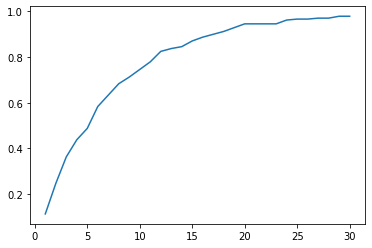

In [ ]:
plt.plot(range(1,31), IVSN_accu[1:31])

In [ ]:
with open("../results/NaturalDesign/naturaldesign_IVSN_accu_performance.pkl", "wb") as tf:
    pickle.dump(IVSN_accu, tf)